In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
from scipy.linalg import norm
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pylab as pylab
# params = {'legend.fontsize': 10,
#          'axes.labelsize': 10,
#          'axes.titlesize':10,
#          'xtick.labelsize':10,
#          'ytick.labelsize':10,
#           'axes.titlesize' : 10}
# pylab.rcParams.update(params)
plt.rcdefaults()
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import pickle

In [2]:
def calc_one_zero_error(T,Estimate, ratio = True):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    error = np.sum(~(np.sign(T[np.triu_indices(T.shape[0], k = 1)]) == np.sign(Estimate[np.triu_indices(Estimate.shape[0], k = 1)])))
    if ratio:
        error = error/float(d*(d-1)/2)
    return error

def calc_f1(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.f1_score(y_true,y_pred)

def calc_f1(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.f1_score(y_true,y_pred)

def calc_precision(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.precision_score(y_true,y_pred)

def calc_recall(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.recall_score(y_true,y_pred)

def calc_density(prec):
    tmp = prec.copy()
    np.fill_diagonal(tmp,0)
    G = nx.from_numpy_array(tmp)
    # G = nx.fast_gnp_random_graph(300,0.3)
    return nx.density(G)

def calc_roc(T,Estimate):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    y_true = np.abs(np.sign(T[np.triu_indices(d, 1)]))
    y_pred = np.abs(np.sign(Estimate[np.triu_indices(d, 1)]))
    return sklearn.metrics.recall_score(y_true,y_pred)



def gen_all_all_zero(d,s, v1 = 1.1, v2 = 1.1):

    while True:
        # G =nx.erdos_renyi_graph(d, s, seed=42)


        # A = np.array(nx.adjacency_matrix(G).todense())
        # A[np.tril_indices(d)] = 0
        # U = np.random.binomial(1,0.5,  size = (d,d))
        # A = np.multiply(A, U*np.random.uniform(-0.6,-0.2, size = (d,d)) + (1-U)*np.random.uniform(0.2,0.6, size = (d,d)))
        # A = A+A.T
        # np.fill_diagonal(A, np.sum(np.abs(A),axis=1))


        k = d
        sparsity = s
        # generate the symmetric sparsity mask
        mask = np.random.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = np.random.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.1) * np.identity(k)

        A2 = A.copy()
        A2_SIGNS = np.sign(A2)
        A2 = np.power(np.abs(A2), v1)
        A2 = A2*A2_SIGNS
        np.fill_diagonal(A2,np.diag(A))

        A3 = A2.copy()
        A3_SIGNS = np.sign(A3)
        A3 = np.power(np.abs(A3), v2)
        A3 = A3*A3_SIGNS
        np.fill_diagonal(A3,np.diag(A))


        try:
            np.linalg.inv(A)
            np.linalg.inv(A2)
            np.linalg.inv(A3)
        except:
            continue


        break

    return [A, A2, A3]

# Outer EM test

In [8]:
d = 20
As = gen_all_all_zero(d,0.3)

n = 100

# X1 = mvt.rvs(shape = np.linalg.inv(prec),  df = 4, size = n, random_state=42)
X1 = mvt.rvs(shape = np.linalg.inv(As[0]),  df = 4, size = n, random_state=42)
X2 = mvt.rvs(shape = np.linalg.inv(As[1]),  df = 4, size = n, random_state=43)
X3 = mvt.rvs(shape = np.linalg.inv(As[2]),  df = 4, size = n, random_state=44)
                                   
X = np.vstack((X1,X2,X3))
X.shape



(300, 20)

In [4]:
obs_per_graph = 100
nr_graphs = int(X.shape[0]/obs_per_graph)
dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 200, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="t", time_index=range(X.shape[0]), nu = [4]*nr_graphs, groups = [0]*d)


Error 1.03E-6:  73%|███████▎  | 146/200 [00:00<00:00, 437.03it/s]


In [5]:
obs_per_graph = 100
nr_graphs = int(X.shape[0]/obs_per_graph)
dg_opt_outer = dg.dygl_outer_em(obs_per_graph = obs_per_graph, max_iter = 50, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
dg_opt_outer.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="t", time_index=range(X.shape[0]), nu = [4]*nr_graphs, groups = [0]*d, max_admm_iter = 100)


Error 1.00E-6:  84%|████████▍ | 42/50 [00:01<00:00, 25.49it/s]


In [18]:
d = 20
As = gen_all_all_zero(d,0.3)

n = 50

# X1 = mvt.rvs(shape = np.linalg.inv(prec),  df = 4, size = n, random_state=42)
X1 = mvt.rvs(shape = np.linalg.inv(As[0]),  df = 4, size = n, random_state=42)
X2 = mvt.rvs(shape = np.linalg.inv(As[1]),  df = 4, size = n, random_state=43)
X3 = mvt.rvs(shape = np.linalg.inv(As[2]),  df = 4, size = n, random_state=44)
                                   
X = np.vstack((X1,X2,X3))
X.shape



nr_admm_its = [1, 2, 3,5, 10,20, 50, 100, 200]

theta_dict = {i:[] for i in range(len(nr_admm_its))}
time_elapsed = []
l1_error = []
zo_error = []
f_error = []
nr_its = []
nr_outer_its = []
obs_per_graph = n
nr_graphs = int(X.shape[0]/obs_per_graph)
for i,nr_admm in enumerate(nr_admm_its):
    print(nr_admm)

    elapsed_tmp = []
    nr_its_tmp = []
    l1_tmp = []
    zo_tmp = []
    f_tmp = []
    nr_outer_its_tmp = []
    for j in range(1):

        start = time.time()
        dg_opt1 = dg.dygl_outer_em(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
        dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="t", time_index=range(X.shape[0]), nu = [4]*nr_graphs, 
                    groups = [0]*d, max_admm_iter = nr_admm, verbose = True)

        elapsed = time.time()-start

        elapsed_tmp.append(elapsed)
        nr_its_tmp.append(dg_opt1.iteration)

        l1_error_val = np.mean([norm(dg_opt1.theta[k] - As[k], ord = 1)/norm(As[k],ord=1)  for k in range(len(dg_opt1.theta))])
        l1_tmp.append(l1_error_val)
        f_error_val = np.mean([norm(dg_opt1.theta[k] - As[k], ord = 'fro')/norm(As[k],ord='fro')  for k in range(len(dg_opt1.theta))])
        f_tmp.append(f_error_val)
        zo_error_val = np.mean([calc_one_zero_error(As[k],dg_opt1.theta[k])  for k in range(len(dg_opt1.theta))])
        zo_tmp.append(zo_error_val)
        nr_outer_its_tmp.append(dg_opt1.iteration)




    theta_dict[i] = dg_opt1.theta
    time_elapsed.append(elapsed_tmp)
    nr_its.append(nr_its_tmp)
    l1_error.append(l1_tmp)
    f_error.append(f_tmp)
    zo_error.append(zo_tmp)
    nr_outer_its.append(nr_outer_its_tmp)




1


Error 1.02E-6:  21%|██        | 208/1000 [00:00<00:01, 742.69it/s]


2


Error 1.01E-6:  12%|█▏        | 115/1000 [00:00<00:01, 611.56it/s]


3


Error 1.06E-6:   8%|▊         | 79/1000 [00:00<00:01, 481.60it/s]


5


Error 1.01E-6:   6%|▌         | 60/1000 [00:00<00:02, 344.75it/s]


10


Error 1.02E-6:   5%|▌         | 50/1000 [00:00<00:04, 199.96it/s]


20


Error 1.06E-6:   4%|▍         | 44/1000 [00:00<00:08, 110.81it/s]


50


Error 1.23E-6:   4%|▍         | 42/1000 [00:00<00:19, 49.40it/s]


100


Error 1.22E-6:   4%|▍         | 42/1000 [00:01<00:37, 25.46it/s]


200


Error 1.22E-6:   4%|▍         | 42/1000 [00:03<01:13, 13.08it/s]


In [19]:
# out_dict = {'time_elapsed':time_elapsed, 'nr_admm_its':nr_admm_its, 'l1_error':l1_error, 'zo_error':zo_error, 'f_error':f_error, 'alpha':0.05, 'kappa':0.4, 
# 'n':n, 'obs_per_graph':obs_per_graph, 'nr_admm_its':nr_admm_its, 'nr_outer_its':nr_outer_its , 'theta_dict':theta_dict}
# import pickle
# with open(f'../data/outer_inner/outer_start_t.pkl', 'wb') as handle:
#     pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

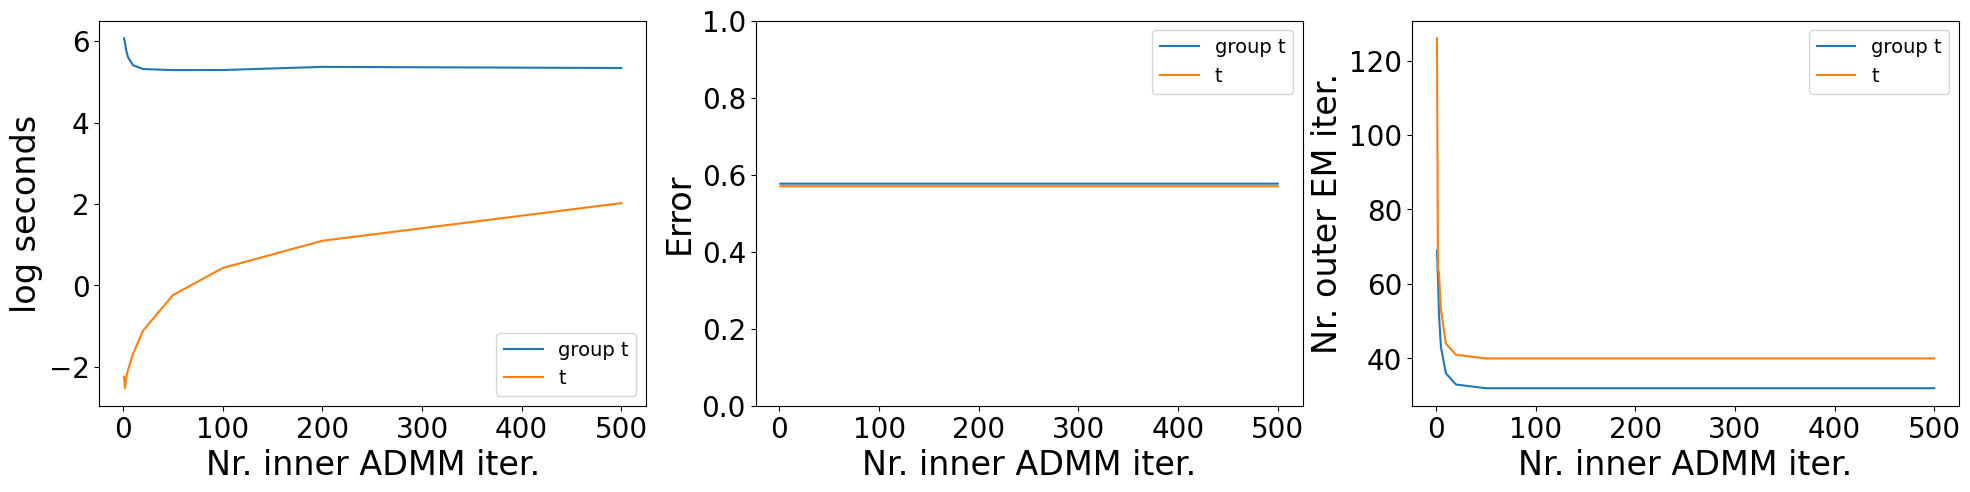

In [17]:
with open(f'../data/outer_inner/outer_em_group-t.pkl', 'rb') as handle:
    out_dict = pickle.load(handle)

with open(f'../data/outer_inner/outer_em_t.pkl', 'rb') as handle:
    out_dict_t = pickle.load(handle)

fig, ax = plt.subplots(1,3, figsize = (24,5))

ax[0].plot(out_dict['nr_admm_its'], np.log([np.median(out_dict['time_elapsed'][i]) for i in range(len(out_dict['nr_admm_its']))]), label = 'group t')
ax[0].plot(out_dict_t['nr_admm_its'], np.log([np.median(out_dict_t['time_elapsed'][i]) for i in range(len(out_dict_t['nr_admm_its']))]), label = 't')
ax[0].set_xlabel("Nr. inner ADMM iter.", fontdict = {'fontsize':24})
ax[0].set_ylabel("log seconds", fontdict = {'fontsize':24})
ax[0].tick_params(axis='both', which='major', labelsize=20)
legend = ax[0].legend(fontsize = 14)
legend.get_title().set_fontsize('18')
# ax[0].set_xticks(out_dict['nr_admm_its'])

#ax[1].plot(nr_admm_its,[np.mean(out_dict['l1_error'][i]) for i in range(len(out_dict['l1_error']))], label ='l1')
#ax[1].plot(nr_admm_its,[np.mean(out_dict['zo_error'][i]) for i in range(len(out_dict['zo_error']))], label ='Zero-One')
ax[1].plot(out_dict['nr_admm_its'],[np.mean(out_dict['f_error'][i]) for i in range(len(out_dict['f_error']))], label ='group t')
ax[1].plot(out_dict_t['nr_admm_its'],[np.mean(out_dict_t['f_error'][i]) for i in range(len(out_dict_t['f_error']))], label ='t')
legend = ax[1].legend(fontsize = 14)
legend.get_title().set_fontsize('18')
ax[1].set_xlabel("Nr. inner ADMM iter.", fontdict = {'fontsize':24})
ax[1].set_ylabel("Error", fontdict = {'fontsize':24})
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_ylim((0,1))


ax[2].plot(out_dict['nr_admm_its'],[np.mean(out_dict['nr_outer_its'][i]) for i in range(len(out_dict['nr_outer_its']))], label ='group t')
ax[2].plot(out_dict_t['nr_admm_its'],[np.mean(out_dict_t['nr_outer_its'][i]) for i in range(len(out_dict_t['nr_outer_its']))], label ='t')
legend = ax[2].legend(fontsize = 14)
legend.get_title().set_fontsize('18')
ax[2].set_xlabel("Nr. inner ADMM iter.", fontdict = {'fontsize':24})
ax[2].set_ylabel("Nr. outer EM iter.", fontdict = {'fontsize':24})
ax[2].tick_params(axis='both', which='major', labelsize=20)

#ax[1].set_xticks(out_dict['nr_admm_its'])


# Inner EM

In [30]:
d = 20
As = gen_all_all_zero(d,0.3)

n = 50

# X1 = mvt.rvs(shape = np.linalg.inv(prec),  df = 4, size = n, random_state=42)
X1 = mvt.rvs(shape = np.linalg.inv(As[0]),  df = 4, size = n, random_state=42)
X2 = mvt.rvs(shape = np.linalg.inv(As[1]),  df = 4, size = n, random_state=43)
X3 = mvt.rvs(shape = np.linalg.inv(As[2]),  df = 4, size = n, random_state=44)
                                   
X = np.vstack((X1,X2,X3))
X.shape



nr_em_its = [1, 2, 3,5, 10,20, 50, 100, 200]

theta_dict = {i:[] for i in range(len(nr_admm_its))}
time_elapsed = []
l1_error = []
zo_error = []
f_error = []
nr_its = []
nr_outer_its = []

obs_per_graph = n
for i,nr_em_it in enumerate(nr_em_its):
    print(nr_admm)

    elapsed_tmp = []
    nr_its_tmp = []
    l1_tmp = []
    zo_tmp = []
    f_tmp = []
    nr_outer_its_tmp = []
    for j in range(1):

        start = time.time()
        dg_opt1 = dg.dygl(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.1, kappa = obs_per_graph*0.1, kappa_gamma=obs_per_graph*0.1, tol = 1e-6)
        dg_opt1.fit(X, nr_workers=1, temporal_penalty="element-wise", lik_type="group-t", time_index=range(X.shape[0]), nu = [[4]*d]*nr_graphs, 
                    groups = [0]*d, nr_em_itr = nr_em_it, verbose = True, nr_quad = 10)

        elapsed = time.time()-start

        elapsed_tmp.append(elapsed)
        nr_its_tmp.append(dg_opt1.iteration)

        l1_error_val = np.mean([norm(dg_opt1.theta[k] - As[k], ord = 1)/norm(As[k],ord=1)  for k in range(len(dg_opt1.theta))])
        l1_tmp.append(l1_error_val)
        f_error_val = np.mean([norm(dg_opt1.theta[k] - As[k], ord = 'fro')/norm(As[k],ord='fro')  for k in range(len(dg_opt1.theta))])
        f_tmp.append(f_error_val)
        zo_error_val = np.mean([calc_one_zero_error(As[k],dg_opt1.theta[k])  for k in range(len(dg_opt1.theta))])
        zo_tmp.append(zo_error_val)
        nr_outer_its_tmp.append(dg_opt1.iteration)




    theta_dict[i] = dg_opt1.theta
    time_elapsed.append(elapsed_tmp)
    nr_its.append(nr_its_tmp)
    l1_error.append(l1_tmp)
    f_error.append(f_tmp)
    zo_error.append(zo_tmp)
    nr_outer_its.append(nr_outer_its_tmp)




200


Error 2.10E-3:   3%|▎         | 32/1000 [03:13<1:37:09,  6.02s/it]

KeyboardInterrupt: 

In [29]:
out_dict = {'time_elapsed':time_elapsed, 'nr_en_its':nr_em_its, 'l1_error':l1_error, 'zo_error':zo_error, 'f_error':f_error, 'alpha':0.05, 'kappa':0.4, 
'n':n, 'obs_per_graph':obs_per_graph,  'nr_outer_its':nr_outer_its , 'theta_dict':theta_dict, 'd':X.shape[0]}
import pickle
with open(f'../data/outer_inner/inner_start_t.pkl', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
out_dict.keys()

dict_keys(['time_elapsed', 'nr_en_its', 'l1_error', 'zo_error', 'f_error', 'alpha', 'kappa', 'n', 'obs_per_graph', 'nr_outer_its', 'theta_dict', 'd', 'lik_type'])

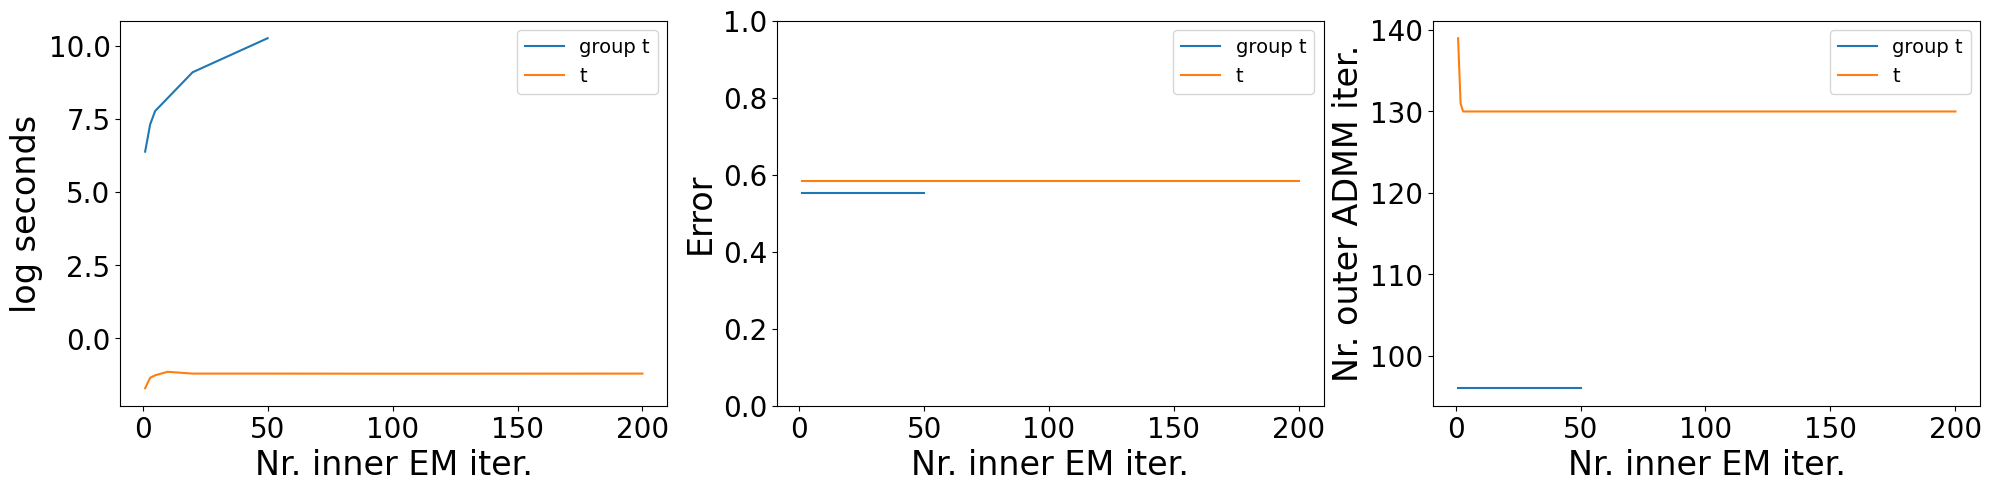

In [16]:
with open(f'../data/outer_inner/inner_em_group-t.pkl', 'rb') as handle:
    out_dict = pickle.load(handle)

with open(f'../data/outer_inner/inner_start_t.pkl', 'rb') as handle:
    out_dict_t = pickle.load(handle)

fig, ax = plt.subplots(1,3, figsize = (24,5))

ax[0].plot(out_dict['nr_en_its'], np.log([np.median(out_dict['time_elapsed'][i]) for i in range(len(out_dict['nr_en_its']))]), label = 'group t')
ax[0].plot(out_dict_t['nr_en_its'], np.log([np.median(out_dict_t['time_elapsed'][i]) for i in range(len(out_dict_t['nr_en_its']))]), label = 't')
ax[0].set_xlabel("Nr. inner EM iter.", fontdict = {'fontsize':24})
ax[0].set_ylabel("log seconds", fontdict = {'fontsize':24})
ax[0].tick_params(axis='both', which='major', labelsize=20)
legend = ax[0].legend(fontsize = 14)
legend.get_title().set_fontsize('18')
# ax[0].set_xticks(out_dict['nr_admm_its'])

#ax[1].plot(nr_admm_its,[np.mean(out_dict['l1_error'][i]) for i in range(len(out_dict['l1_error']))], label ='l1')
#ax[1].plot(nr_admm_its,[np.mean(out_dict['zo_error'][i]) for i in range(len(out_dict['zo_error']))], label ='Zero-One')
ax[1].plot(out_dict['nr_en_its'],[np.mean(out_dict['f_error'][i]) for i in range(len(out_dict['f_error']))], label ='group t')
ax[1].plot(out_dict_t['nr_en_its'],[np.mean(out_dict_t['f_error'][i]) for i in range(len(out_dict_t['f_error']))], label ='t')
legend = ax[1].legend(fontsize = 14)
legend.get_title().set_fontsize('18')
ax[1].set_xlabel("Nr. inner EM iter.", fontdict = {'fontsize':24})
ax[1].set_ylabel("Error", fontdict = {'fontsize':24})
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_ylim((0,1))


ax[2].plot(out_dict['nr_en_its'],[np.mean(out_dict['nr_outer_its'][i]) for i in range(len(out_dict['nr_outer_its']))], label ='group t')
ax[2].plot(out_dict_t['nr_en_its'],[np.mean(out_dict_t['nr_outer_its'][i]) for i in range(len(out_dict_t['nr_outer_its']))], label ='t')
legend = ax[2].legend(fontsize = 14)
legend.get_title().set_fontsize('18')
ax[2].set_xlabel("Nr. inner EM iter.", fontdict = {'fontsize':24})
ax[2].set_ylabel("Nr. outer ADMM iter.", fontdict = {'fontsize':24})
ax[2].tick_params(axis='both', which='major', labelsize=20)

#ax[1].set_xticks(out_dict['nr_admm_its'])


In [11]:
norm(theta_dict[2] - theta_dict[3])

9.526321603737784e-07

# Outer vs Inner

In [12]:
ds = [5, 10, 20, 50, 80, 100, 150, 300]
alpha_prob = [0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ]
alpha = 0.05
kappa = 0.4
tol = 1e-8
n = 1000
obs_per_graph = 100
prec_dict ={}

dens_inner = []
time_inner = []
F_inner = []
zo_inner = []
l1_inner = []

dens_outer = []
time_outer = []
F_outer = []
zo_outer = []
l1_outer = []


for i,d in enumerate(ds):
    print(d)

    prec = make_sparse_spd_matrix(d, alpha=alpha_prob[i], smallest_coef=-0.9, largest_coef=0.9, norm_diag = True, random_state = 42)
    tmp = prec.copy()
    np.fill_diagonal(tmp,0)
    G = nx.from_numpy_array(tmp)
    print("\n")

    prec_dict[i] = prec


    X1 = np.random.multivariate_normal(mean = np.zeros(prec.shape[0]),cov = np.linalg.inv(prec), size = n)
    X = X1



    start = time.time()
    dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*alpha, kappa = obs_per_graph*kappa, tol = tol)
    dg_opt1.fit(X, nr_workers=1, temporal_penalty="global-reconstruction", lik_type="t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = 4, em_tol = 1e-6)
    elapsed = time.time()-start
    dens_inner.append(nx.density(G))
    time_inner.append(elapsed)

    zo_inner.append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
    F_inner.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 'fro')/norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
    l1_inner.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 1)/norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))
        
    start = time.time()
    dg_opt1 = dg.dygl_outer_em(obs_per_graph = obs_per_graph, nr_em_its = 10000, nr_admm_its = 1, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.4, tol_em = tol, tol_admm=1e-6)
    dg_opt1.fit(X,temporal_penalty="global-reconstruction",  nu = 4, time_index=range(X.shape[0]))
    elapsed = time.time()-start
    dens_outer.append(nx.density(G))
    time_outer.append(elapsed)

    zo_outer.append(np.mean([calc_one_zero_error(prec, dg_opt1.theta[k]) for k in range(len(dg_opt1.theta))]))
    F_outer.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 'fro')/norm(prec, ord = 'fro') for k in range(len(dg_opt1.theta))]))
    l1_outer.append(np.mean([norm(prec-dg_opt1.theta[k], ord = 1)/norm(prec, ord = 1) for k in range(len(dg_opt1.theta))]))

out_dict = {'nr_obs_per_graph':obs_per_graph, 'n':n, 'temporal_penalty':'global-reconstruction', 
'density_inner':dens_inner, 'tol':tol, 'time_inner':time_inner, 'zo_inner':zo_inner, 'F_inner':F_inner, 'l1_inner':l1_inner,
'density_outer':dens_outer, 'tol':tol, 'time_outer':time_outer, 'zo_outer':zo_outer, 'F_outer':F_outer, 'l1_inner':l1_outer,
'ds':ds, 'alpha':alpha, 'kappa':kappa, 'max_iter':5000} 
    

with open(f'../data/outer_inner/outer_inner.pkl', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


5




TypeError: 'module' object is not callable

In [8]:
out_dict = {'nr_obs_per_graph':obs_per_graph, 'n':n, 'temporal_penalty':'global-reconstruction', 
'density_inner':dens_inner, 'tol':tol, 'time_inner':time_inner, 'zo_inner':zo_inner, 'F_inner':F_inner, 'l1_inner':l1_inner,
'density_outer':dens_outer, 'tol':tol, 'time_outer':time_outer, 'zo_outer':zo_outer, 'F_outer':F_outer, 'l1_inner':l1_outer,
'ds':ds, 'alpha':alpha, 'kappa':kappa, 'max_iter':5000} 

KeyError: 'F_outer'

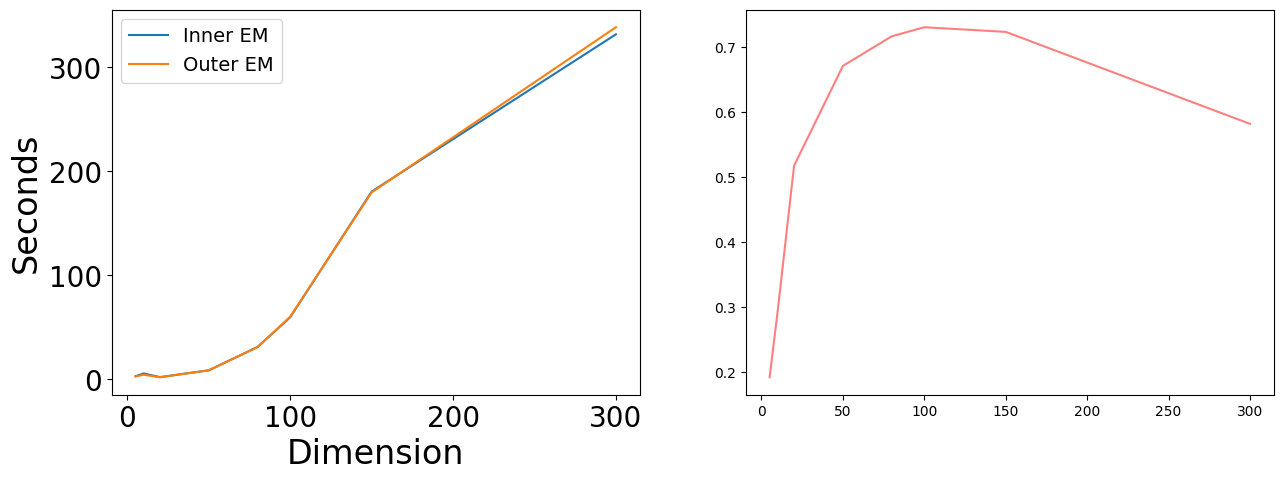

In [11]:
with open(f'../data/outer_inner/outer_inner.pkl', 'rb') as handle:
    out_dict = pickle.load(handle)

fig, ax = plt.subplots(1,2, figsize = (15,5))

ds = [5, 10, 20, 50, 80, 100, 150, 300]
alpha_prob = [0.03, 0.15, 0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99 ]

ax[0].plot(ds, out_dict['time_inner'], label  = 'Inner EM')
ax[0].plot(ds, out_dict['time_outer'], label  = 'Outer EM')
ax[0].set_xlabel("Dimension", fontdict = {'fontsize':24})
ax[0].set_ylabel("Seconds", fontdict = {'fontsize':24})
ax[0].tick_params(axis='both', which='major', labelsize=20)
#ax[0].set_xticks(0])
legend = ax[0].legend(fontsize = 14)
legend.get_title().set_fontsize('18')

#ax[1].plot(ds,l1_inner, label ='l1 Inner', color = "darkblue", alpha = 0.5)
#ax[1].plot(ds,l1_outer, label ='l1 Outer', color = "darkblue", linestyle = 'dashed')
ax[1].plot(ds,out_dict['F_inner'], label ='Frobenius Inner', color = "red", alpha = 0.5)
ax[1].plot(ds,out_dict['F_outer'], label ='Frobenius Outer', color = "red", linestyle = 'dashed')
#ax[1].plot(ds,zo_inner, label ='One-Zero Inner', color = "darkgreen", alpha = 0.5)
# ax[1].plot(ds,zo_outer, label ='One-Zero Outer', color = "darkgreen", linestyle = 'dashed')
#ax[1].plot(nr_admm_its,[np.mean(zo_error[i]) for i in range(len(zo_error))], label ='Zero-One')
#ax[1].plot(nr_admm_its,[np.mean(f_error[i]) for i in range(len(f_error))], label ='Frobenius')
legend = ax[1].legend(title = "Metric",fontsize = 14, bbox_to_anchor = (1.05,1))
legend.get_title().set_fontsize('18')
ax[1].set_xlabel("Nr. inner ADMM iterations", fontdict = {'fontsize':24})
ax[1].set_ylabel("Error", fontdict = {'fontsize':24})
ax[1].tick_params(axis='both', which='major', labelsize=20)
# ax[1].set_xticks([0,5, 10, 15])
